In [2]:
%load_ext autoreload
%autoreload 2

# Setup

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from deepexperiment.utils import one_hot_encoding, one_hot_encoding_batch, ResBlock, get_true_positive_index
from deepexperiment.interpret import DeepShap

2022-10-25 10:45:57.835675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/katarina/Documents/repositories/GitHub/DeepExperiment/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading model and data

In [3]:
model = keras.models.load_model("../models/resnet_small_committee.h5")

2022-10-25 10:47:09.578359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
samples = pd.read_csv('../data/evaluation_set_1_1_CLASH2013_paper.tsv', sep='\t')
pos_samples = samples[samples['label'] == 1].reset_index(drop=True)
neg_samples = samples[samples['label'] == 0].reset_index(drop=True)

# DeepSHAP attribution

DeepSHAP builds on top of DeepLIFT and improves it by using a distibution of background samples instead of a single reference value. This improves the accuracy of the attribution scores, but also increases the computational complexity. The complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [5]:
rand_samples = samples.sample(n=100, replace=False, random_state=42).reset_index(drop=True)
background, _ = one_hot_encoding_batch(rand_samples)

In [6]:
index = get_true_positive_index(pos_samples, model)
print("Looking at index:", index)

miRNA = pos_samples['miRNA'][index]
gene = pos_samples['gene'][index]

data = one_hot_encoding(miRNA, gene)
preds = model.predict(data)
print("Prediction:\nnegative ", preds[0][0], "\npositive ", preds[0][1])

32/32 [==============================] - 5s 107ms/step
Looking at index: 649
1/1 [==============================] - 0s 39ms/step
Prediction:
negative  0.15802939 
positive  0.8419706


In [7]:
deepShap = DeepShap(model, background)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [8]:
_, attribution = deepShap(data)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [9]:
attribution[0,:,:,0].shape

(50, 20)

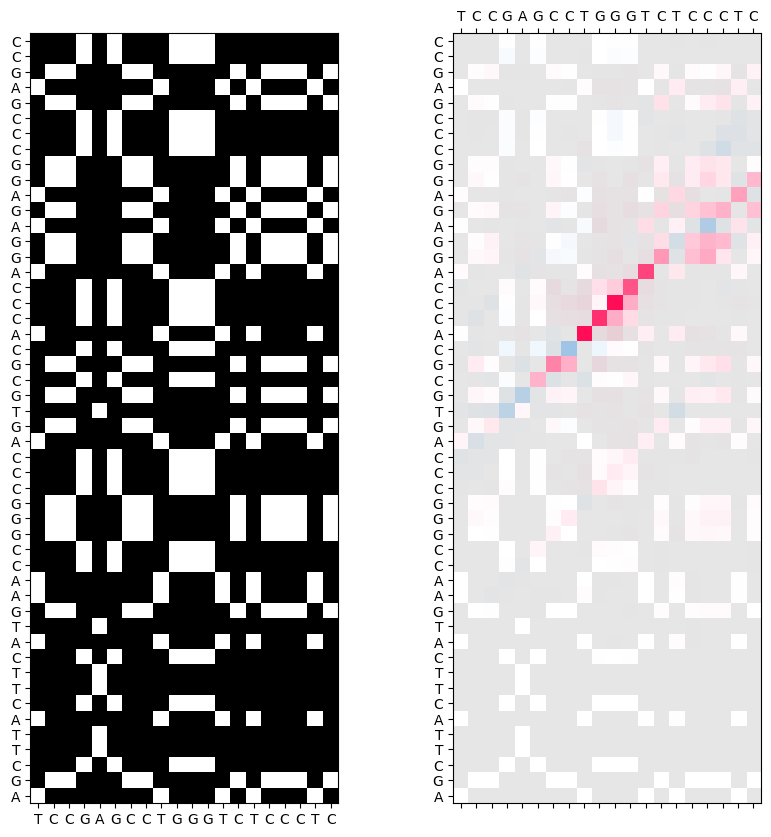

In [10]:
from shap.plots.colors import red_transparent_blue

fig, ax = plt.subplots(1,2, figsize=(10, 10))
ax[0].imshow(data[0,:,:,0], cmap='gray')
ax[0].set_xticks(range(len(miRNA)))
ax[0].set_xticklabels(miRNA)
ax[0].set_yticks(range(len(gene)))
ax[0].set_yticklabels(gene)

pos_shap = attribution
abs_vals = np.stack(np.abs(pos_shap.sum(-1)), 0).flatten()
max_val = np.nanpercentile(abs_vals, 99.9)
ax[1].imshow(data[0,:,:,0], alpha=0.1, cmap='gray')
ax[1].matshow(pos_shap[0,:,:,0], cmap=red_transparent_blue, vmin=-max_val, vmax=max_val)
ax[1].set_xticks(range(len(miRNA)))
ax[1].set_xticklabels(miRNA)
ax[1].set_yticks(range(len(gene)))
ax[1].set_yticklabels(gene)

plt.show();

In [11]:
from deepexperiment.alignment import Attrament

attrament = Attrament()
align_x, align_s, align_y = attrament(gene, miRNA[::-1], attribution[0,:,:,0])


In [12]:
print(" ".join(align_x))
print(" ".join(align_y))

A G C T T A C T T C A T G A A C C G G G C C C A G T G C G C A C C C A G G A G A G G C C C G A G C C
- - - - - - - - - - - - - - - - - - - - - - T C C G A G C C T G G G T C T C C C T C - - - - - - - -


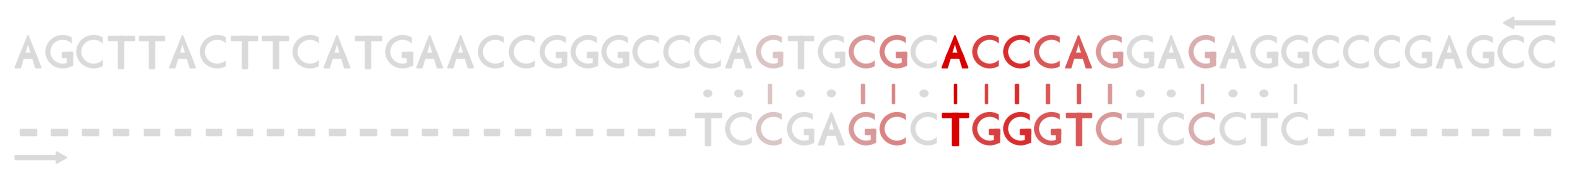

In [186]:
from deepexperiment.visualization import plot_alignment

plot_alignment(align_x, align_s, align_y)

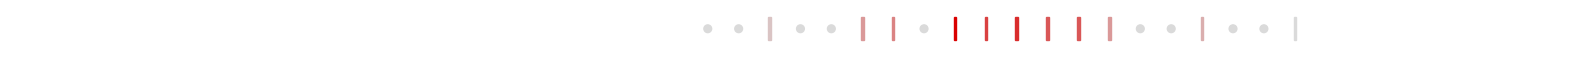

In [187]:
from deepexperiment.visualization import plot_seq_agn_alignment

plot_seq_agn_alignment(align_x, align_s, align_y)

FixedFormatter should only be used together with FixedLocator


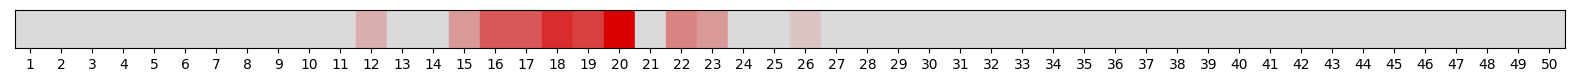

In [188]:
from deepexperiment.visualization import plot_gene_importance

plot_gene_importance(align_s)

FixedFormatter should only be used together with FixedLocator


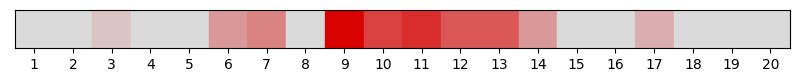

In [189]:
from deepexperiment.visualization import plot_miRNA_importance

plot_miRNA_importance(align_y, align_s)

FixedFormatter should only be used together with FixedLocator


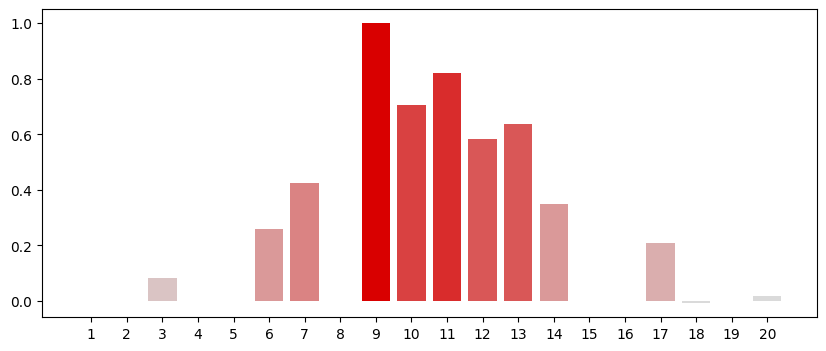

In [190]:
from deepexperiment.visualization import plotbar_miRNA_importance

plotbar_miRNA_importance(align_y, align_s)

FixedFormatter should only be used together with FixedLocator


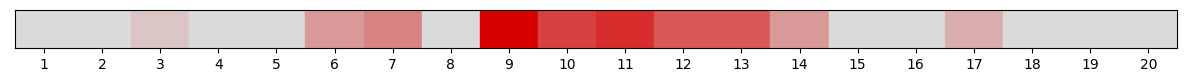

In [199]:
from deepexperiment.visualization import plot_miRNA_importance_w_spaces

plot_miRNA_importance_w_spaces(align_y, align_s)

FixedFormatter should only be used together with FixedLocator


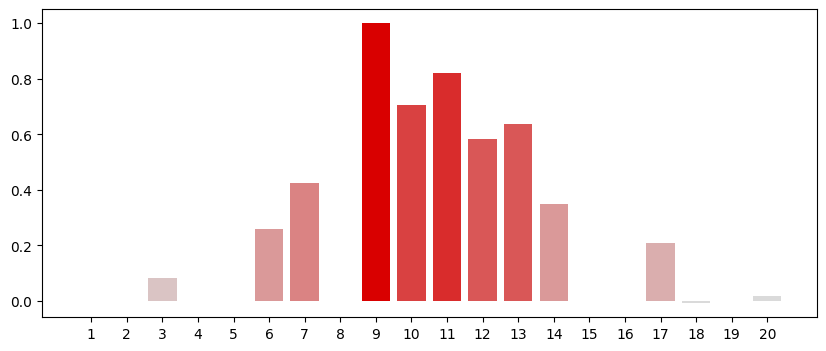

In [196]:
from deepexperiment.visualization import plotbar_miRNA_importance_w_spaces

plotbar_miRNA_importance_w_spaces(align_y, align_s)